In [1]:
import cellpose
import dask.array as da
import napari
import dask
import os
from tqdm.auto import tqdm
from skimage.io import imshow, imsave
from skimage.transform import resize
from skimage.exposure import equalize_hist
from datetime import datetime
import cv2
import sys
sys.path.append('../')
from data_utils import size
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

def norm(img, img_min = 0, img_max = 255):
    if isinstance(img, dask.array.core.Array):
        img = img.compute()
    return cv2.normalize(img, None, alpha=0,beta=255, norm_type=cv2.NORM_MINMAX)

### Load images from zarr and compress into max projections

In [2]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')

### Load masks and chunk into same shape as fluorescent images

The test data set I will work with for the meantime will have a average cell diameter of 250

In [3]:
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/test_diameter/tzxy_stack_d250_ch99.zarr/', 
                     chunks = gfp.chunks)


## Remove small objects

In [4]:
from skimage.io import imshow, imsave
from skimage.morphology import remove_small_objects
import numpy as np

In [5]:
masks_post_process = []
for mask in tqdm(masks):
    mask = remove_small_objects(mask.compute(), min_size = 2000)
    masks_post_process.append(mask)
masks_pp = da.stack(masks_post_process, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

load masks into memory to edit them

In [6]:
masks_pp = masks_pp.rechunk(gfp.chunks)

In [7]:
masks_edited = masks_pp.compute()

normalise and resize the images to make the edit tool in napari not FREAK OUT

In [8]:
training_data_frames = np.linspace(0,74,10,dtype=int)
training_data_frames

array([ 0,  8, 16, 24, 32, 41, 49, 57, 65, 74])

In [9]:
### how much to shrink the image by
div_factor = 4

In [ ]:
for frame in tqdm(training_data_frames):
    v = napari.Viewer()
    
    ### normalise and resize the images
    gfp_frame = gfp[frame].compute()
    #gfp_frame = cv2.normalize(gfp_frame, None, alpha=0,beta=255, norm_type=cv2.NORM_MINMAX)
    gfp_frame = cv2.resize(gfp_frame, tuple([int(i/div_factor) for i in gfp_frame.shape]))
    gfp_frame = equalize_hist(gfp_frame, nbins = 2**16 )# 256)
    #gfp_frame = resize(gfp_frame, tuple([int(i/div_factor) for i in gfp_frame.shape]), order = 0, preserve_range=True)
    
    ### now the mask too
    masks_frame = masks_edited[frame]
    masks_frame = cv2.resize(masks_frame, tuple([int(i/div_factor) for i in masks_frame.shape]), interpolation = cv2.INTER_NEAREST)
    
    ### load first frame in napari for editing
    v.add_image(gfp_frame, name="gfp", #contrast_limits = [0,255], 
                blending = 'additive', colormap= 'green')
    #v.add_image(rfp, name="rfp", contrast_limits = [112,212], blending = 'additive', colormap = 'magenta')
    v.add_labels(masks_frame, name = f'masks pp frame {frame}', visible = True,)    

    ### wait until napari is closed to load the next frame and save out edited GT mask 
    v.show(block = True)
    save_fn = f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/training_data/ground_truth_tiled_masks/r03c03f00p00-GTch99sk{frame}fk1fl1.tiff'
    if not os.path.exists(save_fn):
        imsave(save_fn, masks_frame)
    else:
        date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
        save_fn = f'{save_fn}_{date}.tiff'
        imsave(save_fn, masks_frame)
        

  0%|          | 0/10 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/tmp/ipykernel_1930243/2451389775.py:29: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/training_data/ground_truth_tiled_masks/r03c03f00p00-GTch99sk0fk1fl1.tiff_2022_08_22-05:28:58_pm.tiff is a low contrast image
  imsave(save_fn, masks_frame)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the nap

RuntimeError: Shader compilation error in GL_FRAGMENT_SHADER:
    on line 329: error C0000: syntax error, unexpected $undefined, expecting "::" at token "<undefined>"
      vec4 color0 = $sample(u_volumetex, loc);
    on line 332: error C1503: undefined variable "color0"
      float val0 = colorToVal(color0);
    on line 342: error C0000: syntax error, unexpected $undefined, expecting "::" at token "<undefined>"
      color1 = $sample( u_volumetex, loc+vec3(-step[0],0.0,0.0) );
    on line 343: error C0000: syntax error, unexpected $undefined, expecting "::" at token "<undefined>"
      color2 = $sample( u_volumetex, loc+vec3(step[0],0.0,0.0) );
    on line 349: error C0000: syntax error, unexpected $undefined, expecting "::" at token "<undefined>"
      color1 = $sample( u_volumetex, loc+vec3(0.0,-step[1],0.0) );
    on line 350: error C0000: syntax error, unexpected $undefined, expecting "::" at token "<undefined>"
      color2 = $sample( u_volumetex, loc+vec3(0.0,step[1],0.0) );
    on line 356: error C0000: syntax error, unexpected $undefined, expecting "::" at token "<undefined>"
      color1 = $sample( u_volumetex, loc+vec3(0.0,0.0,-step[2]) );
    on line 357: error C0000: syntax error, unexpected $undefined, expecting "::" at token "<undefined>"
      color2 = $sample( u_volumetex, loc+vec3(0.0,0.0,step[2]) );

IndexError: deque index out of range

IndexError: deque index out of range

IndexError: deque index out of range

/tmp/ipykernel_1930243/2451389775.py:25: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/training_data/ground_truth_tiled_masks/r03c03f00p00-GTch99sk8fk1fl1.tiff is a low contrast image
  imsave(save_fn, masks_frame)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


IndexError: deque index out of range

/tmp/ipykernel_1930243/2451389775.py:25: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/training_data/ground_truth_tiled_masks/r03c03f00p00-GTch99sk16fk1fl1.tiff is a low contrast image
  imsave(save_fn, masks_frame)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [16]:
if not os.path.exists(save_fn):
        imsave(save_fn, masks_frame)
else:
    date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
    save_fn = f'{save_fn}_{date}.tiff'
    imsave(save_fn, masks_frame)

/tmp/ipykernel_1930243/2262231600.py:2: UserWarning: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/training_data/ground_truth_tiled_masks/r03c03f00p00-GTch99sk0fk1fl1.tiff is a low contrast image
  imsave(save_fn, masks_frame)


check to see if masks are being edited

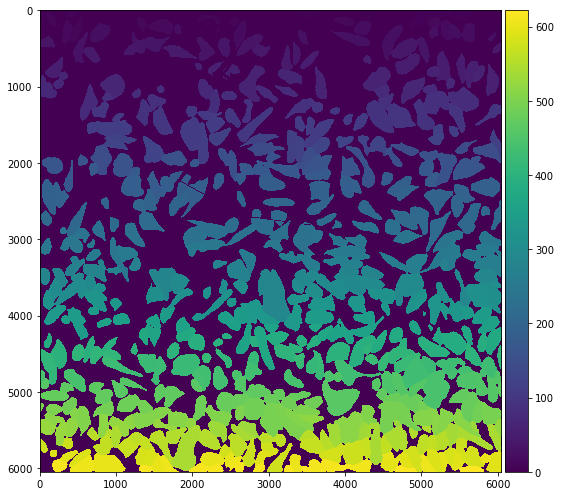

In [14]:
imshow(masks_edited[0])

Rechunk and save out post-processed masks

In [116]:
masks_pp.rechunk(gfp.chunks)

dask.array<rechunk-merge, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [115]:
masks_pp = masks_pp.rechunk(gfp.chunks)

In [117]:
masks_pp.to_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_GTch99.zarr', overwrite = True)